# Scrap book for testing stuff

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial import distance
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

## Define tickers and date span

In [3]:
ticker1_name = 'EWA'
ticker2_name = 'EWC'

start_date = '2020-01-01'
end_date = '2022-01-01'

## Get data

In [4]:
wifi = 1
save_data = 0

if (wifi == 1):
    ticker1 = yf.Ticker(ticker1_name)
    ticker2 = yf.Ticker(ticker2_name)

    data1 = ticker1.history(start=start_date, end=end_date, frequency='1dy')['Close'].rename(ticker1_name)
    data2 = ticker2.history(start=start_date, end=end_date, frequency='1dy')['Close'].rename(ticker2_name)

    df = pd.concat([data1, data2], axis=1).bfill()

    if (save_data == 1):
        df.to_csv('data/' + ticker1_name + '_' + ticker2_name + '.csv')
    
else:
    df = pd.read_csv('data/' + ticker1_name + '_' + ticker2_name + '.csv', parse_dates=True, index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.bfill()

Text(0.5, 1.0, 'EWC')

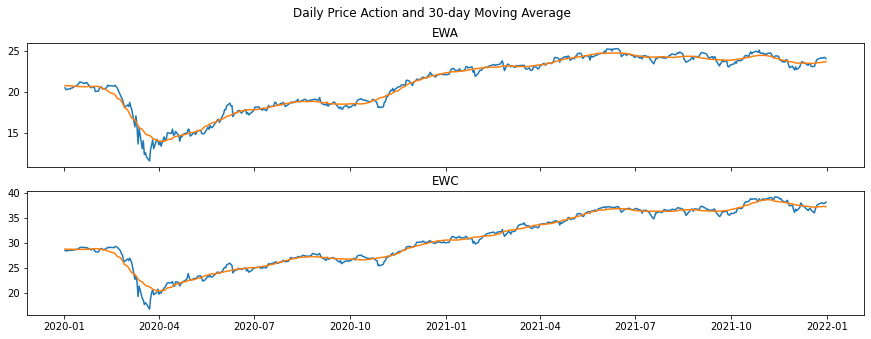

In [5]:
df_mean = pd.concat([df[ticker1_name].rolling(window=30, center=True, min_periods=0).mean(), 
                        df[ticker2_name].rolling(window=30, center=True, min_periods=0).mean()], 
                       axis=1)
df_spread = df[ticker2_name] - df[ticker1_name]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(15, 5))
fig.suptitle('Daily Price Action and 30-day Moving Average')

ax1.plot(df[ticker1_name])
ax1.plot(df_mean[ticker1_name])
ax1.set_title(ticker1_name)

ax2.plot(df[ticker2_name])
ax2.plot(df_mean[ticker2_name])
ax2.set_title(ticker2_name)

## Correlation

Pearson Correlation: measures only linear associasions between random variables, inexpensive O(n), high correlation if close to 1

Distance Correlation: measures both linear and nonlinear association between random variables, more expensive O(n2), high correlation if distance close to 0

In [8]:
corr = df.corr()
print('Pearson Correlation:', corr[ticker1_name][ticker2_name])

Pearson Correlation (close to 1 is better): 0.9642872816377958


In [10]:
dist_corr = distance.correlation(df[ticker1_name], df[ticker2_name])
print('Distance Correlation:', dist_corr)

Distance Correlation: 0.03571271836220413


## Johansen cointegration test

Using log-prices because makes more sense apparently

In [12]:
df_log_price = np.log10(df)
jres = coint_johansen(df_log_price, det_order=0, k_ar_diff=1)

output = pd.DataFrame([jres.lr2,jres.lr1], index=['max_eig_stat',"trace_stat"])
print(output.T,'\n')
print("Critical values(90%, 95%, 99%) of max_eig_stat\n",jres.cvm,'\n')
print("Critical values(90%, 95%, 99%) of trace_stat\n",jres.cvt,'\n')

   max_eig_stat  trace_stat
0      2.783321    3.021731
1      0.238409    0.238409 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



## OLS Regression

In [13]:
# Determine cointegration coefficient
X = df[ticker1_name]
Y = df[ticker2_name]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
# Get beta coefficient: P2 = beta * P1 + alpha (alpha = 0)
beta_coef = model.params[ticker1_name]

summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                    EWC   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     6667.
Date:                Sat, 16 Jul 2022   Prob (F-statistic):          2.20e-292
Time:                        15:05:24   Log-Likelihood:                -896.78
No. Observations:                 505   AIC:                             1798.
Df Residuals:                     503   BIC:                             1806.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4702      0.412     -5.994      0.0

## Basic Trading intervals

Calculate spread, mean spread, and trivial trading intervals based on standard deviation from mean spread

In [14]:
df_spread = df[ticker2_name] - (df[ticker1_name] * beta_coef)
spread_mean = df_spread.mean()
spread_std = df_spread.std()

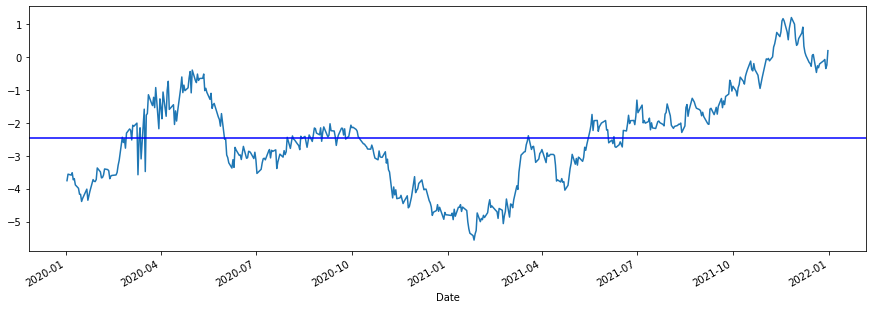

In [15]:
ax3 = df_spread.plot(figsize=(15, 5))
ax3.axhline(y=spread_mean, color='b', linestyle='-')

## Optimising Trading Intervals

In [16]:
U_grid = np.linspace(0, (4*spread_std), num=100)

strategy_stats = np.empty((len(U_grid), 4))

for u in range(len(U_grid)):
    trade_active = 0
    trade_duration = 0
    trade_duration_list = []
    for i in range(len(df_spread)):
        if trade_active == 1:
            if df_spread[i] <= spread_mean:
                trade_active = 0
                trade_duration_list.append(trade_duration)
                trade_duration = 0
            else:
                trade_duration += 1

        elif trade_active == -1:
            if df_spread[i] >= spread_mean:
                trade_active = 0
                trade_duration_list.append(trade_duration)
                trade_duration = 0
            else:
                trade_duration += 1   

        elif df_spread[i] >= spread_mean + U_grid[u]:
            trade_active = 1
            trade_duration += 1

        elif df_spread[i] <= spread_mean - U_grid[u]:
            trade_active = -1
            trade_duration += 1

    strategy_stats[u, 0] = U_grid[u] / spread_std
    strategy_stats[u, 1] = len(trade_duration_list)
    strategy_stats[u, 2] = np.mean(trade_duration_list)
    strategy_stats[u, 3] = np.std(trade_duration_list)

df_strategy_stats = pd.DataFrame(strategy_stats, columns = ['num_std','num_trades','mean_length','std_length'])


/Users/tristanritchie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tristanritchie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tristanritchie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tristanritchie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/tristanritchie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
# num_trades * std * spread_std
res = strategy_stats[:, 1] * (strategy_stats[:, 0] * spread_std)
index = np.argmax(res)
optimal_strat = strategy_stats[index]

print('Number of standard deviations: ',            optimal_strat[0])
print('Number of trades over analysis period: ',    optimal_strat[1])
print('Mean trade duration: ',                      optimal_strat[2])

Number of standard deviations:  0.6868686868686869
Number of trades over analysis period:  7.0
Mean trade duration:  31.285714285714285


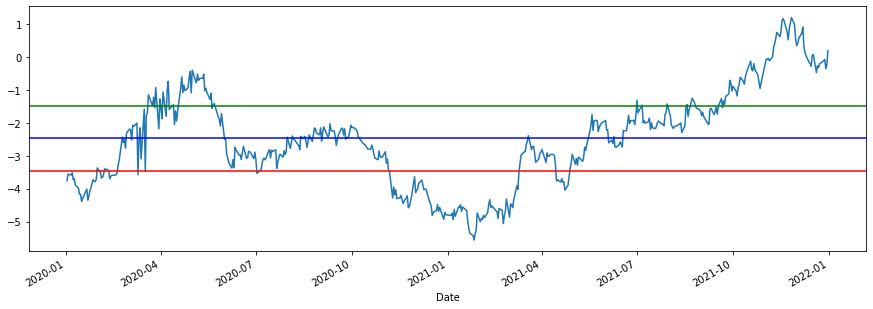

In [19]:
upper = spread_mean + (optimal_strat[0] * spread_std)
lower = spread_mean - (optimal_strat[0] * spread_std)

ax4 = df_spread.plot(figsize=(15, 5))

ax4.axhline(y=lower, color='r', linestyle='-')
ax4.axhline(y=upper, color='g', linestyle='-')
ax4.axhline(y=spread_mean, color='b', linestyle='-')